In [2]:
import os
# Deshabilita la GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  

# Suprime los logs de TensorFlow relacionados con errores e información
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"  

# Suprime las advertencias para una salida más limpia
import warnings
warnings.filterwarnings('ignore')

# Importa TensorFlow y Keras
import tensorflow as tf
import keras

# Imprime las versiones de TensorFlow y Keras instaladas en el entorno
print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")

E0000 00:00:1733344225.535586   23260 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733344225.582220   23260 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow version: 2.18.0
Keras version: 3.6.0


In [3]:
# Importación de módulos estándar
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Importación de módulos de Keras para construcción de modelos de redes neuronales
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Input,  Conv1D
from keras import regularizers
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy, MeanSquaredError
from keras import metrics


# Importación de módulos de scikit-learn para preprocesamiento y evaluación de modelos
from sklearn.metrics import (classification_report, confusion_matrix,mean_squared_error, recall_score, precision_score, 
                             accuracy_score, f1_score, roc_auc_score)
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Importación del módulo time para medir tiempos de ejecución
from time import time

# Configuración de semillas aleatorias para reproducibilidad
np.random.seed(7)
seed = 15
rng = np.random.RandomState(313)

# Configuración para visualizar gráficos en línea en Jupyter Notebook
%matplotlib inline



## Carga y Exploración de los Datos

In [4]:
X_train = pd.read_csv(r"../Datos/BinarioTrainBalanced.csv")
X_test  = pd.read_csv(r"../Datos/BinarioTest1Balanced.csv")

In [5]:
print("\n\t\tDatos de entrenamiento")
nr_clases = X_train['CLASS_LABEL'].value_counts(sort=True)
print("\nCantidad ",nr_clases,"\nPorcentajes", nr_clases*100/X_train.shape[0])
Y_train = X_train['CLASS_LABEL']
X_train = X_train.drop(['CLASS_LABEL'], axis=1)
print(X_train.shape, Y_train.shape)

print("\n\t\tDatos de prueba AE")
nr_clases = X_test['CLASS_LABEL'].value_counts(sort=True)
print("\nCantidad ",nr_clases,"\nPorcentajes", nr_clases*100/X_test.shape[0])
Y_test = X_test['CLASS_LABEL']
X_test = X_test.drop(['CLASS_LABEL'], axis=1)
print(X_test.shape, Y_test.shape)


		Datos de entrenamiento

Cantidad  CLASS_LABEL
0    6212
1    6196
Name: count, dtype: int64 
Porcentajes CLASS_LABEL
0    50.064475
1    49.935525
Name: count, dtype: float64
(12408, 606) (12408,)

		Datos de prueba AE

Cantidad  CLASS_LABEL
0    777
1    774
Name: count, dtype: int64 
Porcentajes CLASS_LABEL
0    50.096712
1    49.903288
Name: count, dtype: float64
(1551, 606) (1551,)


## Entrenamos el modelo

In [7]:
from tensorflow.keras import backend as K

# Definir la métrica R^2
def r2_score(y_true, y_pred):
    ss_res = K.sum(K.square(y_true - y_pred))  # Suma de los residuos al cuadrado
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))  # Suma total de cuadrados
    return 1 - ss_res / (ss_tot + K.epsilon())  # Epsilon para evitar divisiones por cero

### Aumentación para Series Temporales


In [8]:
import numpy as np

def augment_time_series(data, noise_factor=0.1, shift_max=5):
    """Genera vistas augmentadas de series temporales."""
    augmented_1 = data + noise_factor * np.random.normal(size=data.shape)
    shift = np.random.randint(-shift_max, shift_max)
    augmented_2 = np.roll(data, shift, axis=1)
    return augmented_1, augmented_2

# Generar vistas augmentadas
X_train_aug1, X_train_aug2 = augment_time_series(X_train.values)


### SupCon Loss (Supervised Contrastive Loss)

In [9]:
def supervised_contrastive_loss(labels, features, temperature=0.1):
    labels = tf.expand_dims(labels, axis=1)
    mask = tf.cast(tf.equal(labels, tf.transpose(labels)), dtype=tf.float32)  # Conversión a float
    features_normalized = tf.math.l2_normalize(features, axis=1)
    logits = tf.matmul(features_normalized, tf.transpose(features_normalized)) / temperature
    exp_logits = tf.exp(logits)
    log_prob = logits - tf.math.log(tf.reduce_sum(exp_logits, axis=1, keepdims=True))
    loss = -tf.reduce_mean(
        tf.reduce_sum(mask * log_prob, axis=1) / tf.reduce_sum(mask, axis=1)
    )
    return loss


### Modelo Contrastivo

In [9]:
# Definir las métricas configuradas en el modelo
metricas = ['Loss', 'Mean Squared Error', 'Mean Absolute Error', 'R2 Score']

In [10]:
# Definir la dimensión de entrada basada en los datos
dim_entrada = X_train.shape[1]  # 606 características

# Construir el autoencoder
# Encoder
input_layer = Input(shape=(dim_entrada,), name="input_layer_1")
x = Dense(300, activation='relu', name="dense_6")(input_layer) 
x = Dense(200, activation='relu', name="dense_7")(x)            
x = Dense(90, activation='relu', name="dense_8")(x)            

# Espacio latente
latent_layer = Dense(20, activation='relu', name="dense_9")(x) 

# Decoder
x = Dense(90, activation='relu', name="dense_10")(latent_layer) 
x = Dense(200, activation='relu', name="dense_11")(x)           
x = Dense(300, activation='relu', name="dense_12")(x)           
output_layer = Dense(dim_entrada, activation='linear', name="dense_13")(x) 

# Construir el modelo autoencoder
autoencoder = Model(inputs=input_layer, outputs=output_layer)

# Compilar el modelo
autoencoder.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=MeanSquaredError(),
    metrics=['mse', 'mae', r2_score]
)

# Resumen del modelo
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 606)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 300)            │       182,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 200)            │        60,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 90)             │        18,090 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 20)             │         1,820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 90)             │         1,890 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 200)            │        18,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 300)            │        60,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 606)            │       182,406 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 525,006 (2.00 MB)

 Trainable params: 525,006 (2.00 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('dense_9').output)

# Resumen del modelo
encoder.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 606)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 300)            │       182,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 200)            │        60,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 90)             │        18,090 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 20)             │         1,820 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 262,210 (1.00 MB)

 Trainable params: 262,210 (1.00 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:

# Pasar las vistas augmentadas por el encoder
features_aug1 = encoder.predict(X_train_aug1)
features_aug2 = encoder.predict(X_train_aug2)

# Calcular la pérdida contrastiva supervisada
loss = supervised_contrastive_loss(Y_train, tf.concat([features_aug1, features_aug2], axis=0))




388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 555us/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 527us/step


: 

### Entrenamiento

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

@tf.function
def train_step(data1, data2, labels):
    with tf.GradientTape() as tape:
        features1 = encoder(data1, training=True)
        features2 = encoder(data2, training=True)
        loss = supervised_contrastive_loss(labels, tf.concat([features1, features2], axis=0))
    gradients = tape.gradient(loss, encoder.trainable_variables)
    optimizer.apply_gradients(zip(gradients, encoder.trainable_variables))
    return loss

# Entrenamiento
for epoch in range(10):  # Ajustar el número de épocas
    loss = train_step(tf.convert_to_tensor(X_train_aug1, dtype=tf.float32),
                      tf.convert_to_tensor(X_train_aug2, dtype=tf.float32),
                      tf.convert_to_tensor(Y_train, dtype=tf.int32))
    print(f"Epoch {epoch + 1}, Loss: {loss.numpy()}")


In [9]:
from tensorflow.keras.callbacks import EarlyStopping

# Configurar EarlyStopping
early_stopping = EarlyStopping(
    monitor='loss',  # Monitorea la pérdida en los datos de entrenamiento
    patience=10,     # Detiene el entrenamiento si no hay mejora en 10 épocas
    restore_best_weights=True  # Restaura los pesos del mejor modelo
)

# Reentrenar el autoencoder con EarlyStopping
history = autoencoder.fit(
    X_train, X_train,
    epochs=100,
    batch_size=128,
    verbose=1,
    callbacks=[early_stopping]  # Agregar EarlyStopping
)


Epoch 1/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0639 - mae: 0.1285 - mse: 0.0639 - r2_score: 0.6196
Epoch 2/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0034 - mae: 0.0353 - mse: 0.0034 - r2_score: 0.9795
Epoch 3/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0021 - mae: 0.0280 - mse: 0.0021 - r2_score: 0.9878
Epoch 4/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0020 - mae: 0.0277 - mse: 0.0020 - r2_score: 0.9880
Epoch 5/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0019 - mae: 0.0275 - mse: 0.0019 - r2_score: 0.9884
Epoch 6/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0016 - mae: 0.0263 - mse: 0.0016 - r2_score: 0.9904
Epoch 7/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0014 - mae: 0.0244 - mse: 0.0014 - r2_score: 0.9919
Epoch 8/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0012 - mae: 0.0234 - mse: 0.0012 - r2_score: 0.9928
Epoch 9/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0011 - mae: 0.0227 - mse: 0.0011 - 

In [11]:
# Guardar el modelo reentrenado
#autoencoder.save("../Modelos/Binary_AE_MPL_v2.keras")
#print("Modelo reentrenado guardado exitosamente.")

## Visualizacion de recontrucción

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Función para visualizar la reconstrucción de una señal específica
def visualizar_reconstruccion(autoencoder, datos_originales, indice):
    """
    Visualiza una señal original y su reconstrucción realizada por el autoencoder.
    
    Parámetros:
    - autoencoder: El modelo autoencoder entrenado.
    - datos_originales: Conjunto de datos original (DataFrame o array).
    - indice: Índice de la señal a visualizar (fila del conjunto de datos).
    """
    # Asegurarse de que los datos son un array NumPy
    if isinstance(datos_originales, pd.DataFrame):
        datos_originales = datos_originales.values  # Convertir DataFrame a array si es necesario
    
    # Validar el índice
    if indice < 0 or indice >= datos_originales.shape[0]:
        raise ValueError(f"Índice fuera de rango. Debe estar entre 0 y {datos_originales.shape[0] - 1}.")
    
    # Obtener la señal original (fila)
    señal_original = datos_originales[indice]
    
    # Reconstruir la señal usando el autoencoder
    señal_reconstruida = autoencoder.predict(señal_original.reshape(1, -1), verbose=0)[0]
    
    # Graficar la señal original y reconstruida
    plt.figure(figsize=(9, 4))
    plt.plot(señal_original, label='Señal Original', color='blue', alpha=0.7, linewidth=2)
    plt.plot(señal_reconstruida, label='Señal Reconstruida', color='red', linestyle='dashed', alpha=0.7, linewidth=2)
    plt.title(f"Reconstrucción de la Señal - Índice: {indice}", fontsize=14)
    plt.xlabel("Índice de Característica", fontsize=12)
    plt.ylabel("Valor", fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


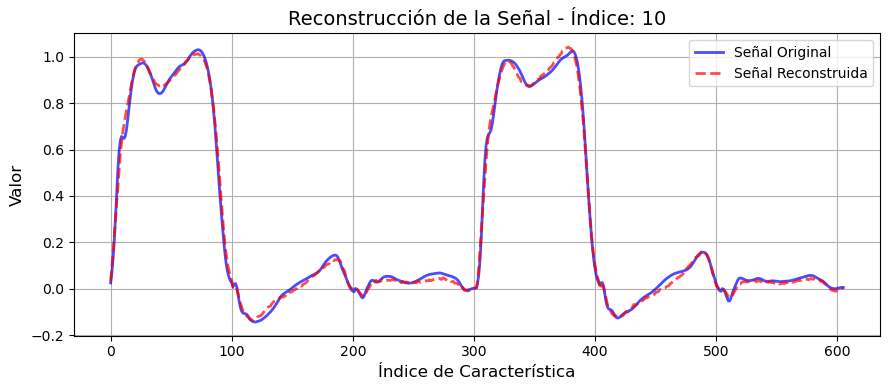

In [13]:

# Seleccionar una señal para visualizar
indice_señal = 10  # Cambia este índice para visualizar otras señales

# Llamar a la función de visualización
visualizar_reconstruccion(autoencoder, X_train, indice_señal)


## Visualizacion de espacios

### Espacio latente

In [14]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Crear el encoder como modelo independiente
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('dense_9').output)
#encoder = Model(inputs=autoencoder.input, outputs=autoencoder.layers[4].output)  # Última capa del encoder

# Generar el espacio latente utilizando el encoder
espacio_latente = encoder.predict(X_train)

# Verificar las dimensiones del espacio latente
print(f"Dimensiones de X_train_ae: {X_train.shape}")
print(f"Dimensiones del espacio latente: {espacio_latente.shape}")

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 595us/step
Dimensiones de X_train_ae: (12408, 606)
Dimensiones del espacio latente: (12408, 20)


In [15]:
# Guardar el encoder
encoder.save("../Modelos/Binary_Encoder_MPL_v2.keras")
print("Encoder guardado exitosamente.")

Encoder guardado exitosamente.


In [16]:
# Reducir el espacio latente a 2 dimensiones usando t-SNE
tsne = TSNE(n_components=2, random_state=42)
espacio_latente_2D = tsne.fit_transform(espacio_latente)

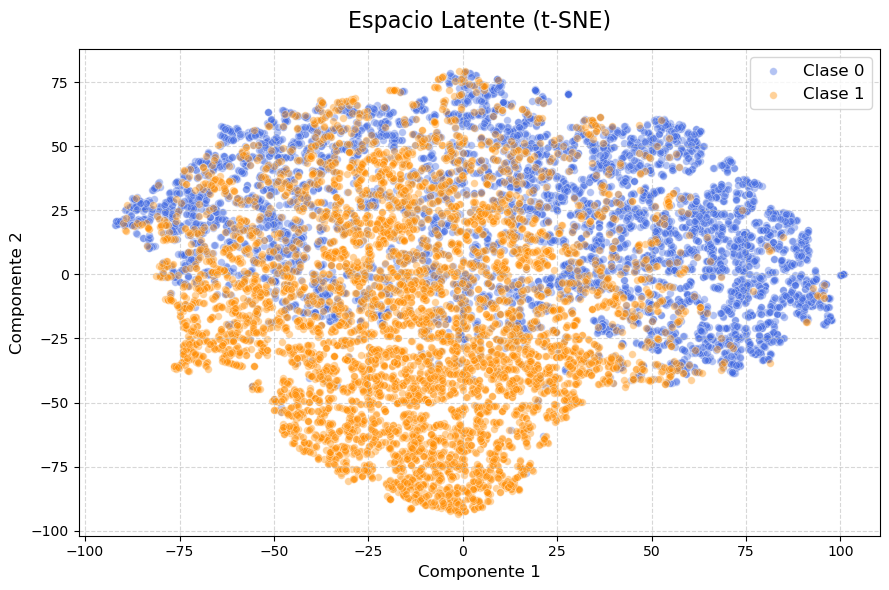

In [18]:
# Visualizar el espacio latente utilizando un scatter plot con mejoras
plt.figure(figsize=(9, 6))
colores = ['royalblue', 'darkorange']  # Colores para las clases

for i, clase in enumerate([0, 1]):
    indices = Y_train == clase
    plt.scatter(
        espacio_latente_2D[indices, 0], 
        espacio_latente_2D[indices, 1], 
        label=f'Clase {clase}',
        alpha=0.4,  # Transparencia para observar superposición
        c=colores[i],
        edgecolor='w',  # Borde blanco para mayor claridad
        linewidth=0.5,
        s=30  # Tamaño de los puntos
    )

# Configuración del gráfico
plt.title("Espacio Latente (t-SNE)", fontsize=16, pad=15)
plt.xlabel("Componente 1", fontsize=12)
plt.ylabel("Componente 2", fontsize=12)
plt.legend(fontsize=12, loc='upper right')
plt.grid(visible=True, linestyle='--', alpha=0.5)  # Agregar una cuadrícula suave
plt.tight_layout()
plt.show()

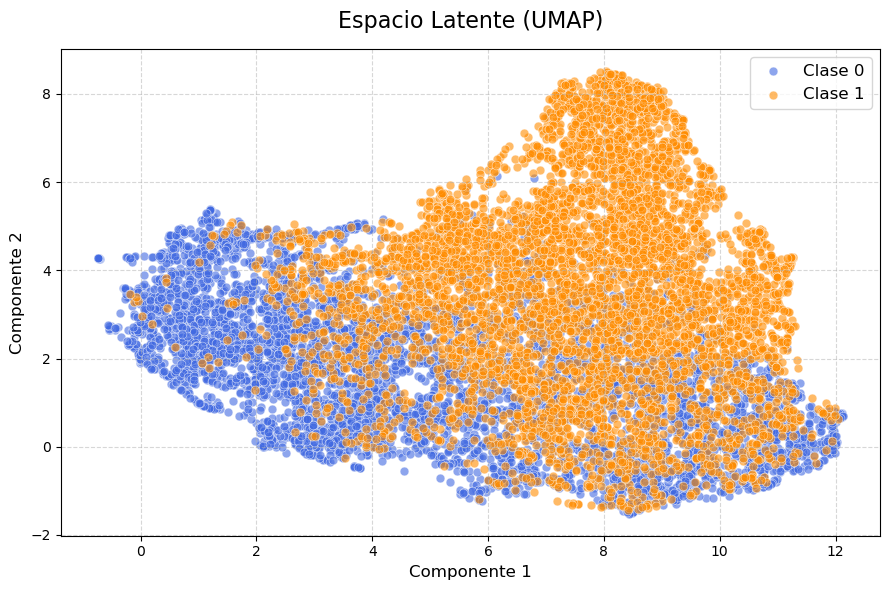

In [20]:
import umap
import matplotlib.pyplot as plt
import numpy as np

# Configurar UMAP
umap_reducer = umap.UMAP(
    n_components=2,      # Reducir a 2 dimensiones
    n_neighbors=15,      # Controla la cantidad de vecinos locales considerados
    min_dist=0.1,        # Controla cuán apretados están los puntos en la proyección
    random_state=42      # Reproducibilidad
)

# Reducir el espacio latente a 2 dimensiones
espacio_latente_2D_umap = umap_reducer.fit_transform(espacio_latente)

# Visualizar el espacio latente utilizando UMAP
plt.figure(figsize=(9, 6))
colores = ['royalblue', 'darkorange']  # Colores para las clases

# Graficar los puntos para cada clase
for i, clase in enumerate([0, 1]):
    indices = Y_train == clase
    plt.scatter(
        espacio_latente_2D_umap[indices, 0], 
        espacio_latente_2D_umap[indices, 1], 
        label=f'Clase {clase}',
        alpha=0.6,  # Transparencia para superposición
        c=colores[i],
        edgecolor='w',  # Bordes blancos para claridad
        linewidth=0.5,
        s=40  # Tamaño de los puntos
    )

# Configuración del gráfico
plt.title("Espacio Latente (UMAP)", fontsize=16, pad=15)
plt.xlabel("Componente 1", fontsize=12)
plt.ylabel("Componente 2", fontsize=12)
plt.legend(fontsize=12, loc='upper right')
plt.grid(visible=True, linestyle='--', alpha=0.5)  # Agregar una cuadrícula suave
plt.tight_layout()
plt.show()
